<a href="https://colab.research.google.com/github/javiserna/Rotational-models-of-CTTS/blob/main/RotEvol_REFUGEE_Baraffe%2BCTTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [ ]:
!pip install ipython-autotime
import concurrent.futures
%load_ext autotime

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.interpolate import interp1d
import random
from scipy import optimize

def REFUGEE(Mass, Prot, Macc, Tdisk, Bfield, betta, gamma, APSW):

  #####################################################
  Msun=1.98e+33 #g
  Rsun=6.96e+10 #cm
  Omegasun=2.8e-06 #s-1
  Isun=6.4e+53 #g*cm2
  Jsun=1.8e+48 #g*cm2/s
  Kw=9e48#2.7e47#*3.154e7*3.154e7 #g*cm2/yr2
  tg=35e+6 #Escala de tiempo gravitacional en yr
  ta=2.1e+6 #2.3e6 yr fedele 2010
  G=6.67259e-8 #cgs
  yr2sec=3.154e+7 #s
  #####################################################

  #Lectura del archivo de baraffe

  baraffe=scipy.genfromtxt('/drive/My Drive/Colab Notebooks/Baraffe/'+'Baraffe_'+str(Mass)+'Msun.dat', comments='#', dtype='S')

  #Datos del modelo solar de Baraffe 2015

  RADIUS=baraffe[:,5].astype(float)
  AGE=pow(10,baraffe[:,1].astype(float))
  TEFF=baraffe[:,2].astype(float)
  LUM=baraffe[:,3].astype(float)
  K2ENV=baraffe[:,11].astype(float)
  K2CORE=baraffe[:,12].astype(float)

  R=interp1d(AGE/tg,RADIUS,kind='linear')
  C=interp1d(AGE/tg,K2ENV,kind='linear')
  D=interp1d(AGE/tg,K2CORE,kind='linear')

  S=interp1d(AGE/tg,LUM,kind='linear')
  T=interp1d(AGE/tg,TEFF,kind='linear')

  ##############################################################################################

  #Tiempo normalizado a la escala de tiempo gravitacional tg
  time=np.arange(5e5,Tdisk,1e5)/tg #5e9

  radius=R(time)
  K2env=C(time)
  K2core=D(time)
  K2total=(K2env*K2env)+(K2core*K2core)

  #Masa del disco en unidades solares
  #Mdisk=0.01
  #Tasa de acrecion
  Madot=(Macc)*np.exp(-time*tg/ta)

  #Masa estelar (Solucion Analitica)
  #Mstar=-(ta)*(Macc)*np.exp(-time*tg/ta)*(1-APSW)+1
  Mstar=-(ta)*(Macc)*np.exp(-time*tg/ta)*(1-APSW)+ Mass


  #Momento de inercia de la estrella
  Istar=interp1d(time,K2total*radius*radius*Mstar, kind='linear')
  I_total=Istar(time)

  #Derivada del Radio Estelar (En desuso)

  def R_dot(radius,time):
    "Derivada del radio estelar"
    rdot=[]
    for i in range(len(time)):
      if (i==0):
        rdot.append((radius[i+1]-radius[i])/(time[i+1]-time[i]))
      if (i==len(time)-1):
        return np.array(rdot)
      else:
        rdot.append((radius[i+1]-radius[i])/(time[i+1]-time[i]))

  #Interpolacion de la derivada del radio
  Rdot=interp1d(time,R_dot(radius,time),kind='linear')

  #Derivada del momento de inercia

  def Idot(I_total,time):
    "Derivada del momento de inercia"
    I_dot=[]
    for i in range(len(time)):
      if (i==0):
        I_dot.append((I_total[i+1]-I_total[i])/(time[i+1]-time[i]))
      if (i==len(time)-1):
        return np.array(I_dot)
      else:
        I_dot.append((I_total[i+1]-I_total[i])/(time[i+1]-time[i]))


  #Interpolacion de la derivada del momento de inercia

  J=interp1d(time,Idot(I_total,time),kind='linear')
  I_dot=J(time)

  ##################################################################################################

  #Ecuacion diferencial a resolver

  def Omega_dot(Omega, time, tdisk, B, betta, gamma, APSW):

    #Tasa de acrecion
    Madot=(Macc)*np.exp(-time*tg/ta)

    #Masa de la estrella
    Mstar=-(ta)*(Macc)*np.exp(-time*tg/ta)*(1-APSW)+ Mass

    #Campo Magnetico
    #B=2500 #Unidad de Gauss
    #global betta, gamma
    #betta=0.01
    #gamma=1

    #Fase en donde existe un disco protoplanetario
    if (time<tdisk):
      #Velocidad angular normalizada a la velocidad de ruptura
      f=Omega*Omegasun*np.sqrt(pow(R(time)*Rsun,3.0)/(G*Mstar*Msun))

      #Limite para la velocidad angular normalizada
      if (f>1):
        f=1
        Omega=f/(Omegasun*np.sqrt(pow(R(time)*Rsun,3.0)/(G*Mstar*Msun)))

      #Radio de Corrotacion
      Rco=pow((G*Mstar*Msun/(pow(Omega*Omegasun,2.0))),1.0/3.0)/Rsun

      #Radio Externo a la region de corrotacion
      Rout=Rco*pow(1+betta*gamma, 2.0/3.0)

      #Radio Interno a la region de corrotacion
      Rin=Rco*pow(1-betta*gamma, 2.0/3.0)

      #Dipolo magnetico
      dipole=B*pow(R(time)*Rsun,3.0)

      psi=2*pow(dipole,2.0)*pow(Madot*Msun/yr2sec,-1.0)*pow(np.sqrt(G*Mstar*Msun),-1.0)*pow(R(time)*Rsun,-3.5)

      #Ecuacion 15 (MP05) a resolver a traves del metodo Newton Raphson (Proposito: Encontrar el valor de x=Rt/Rco)
      y=[lambda x: pow(x, -3.5) - pow(x, -2.0) - (betta*pow(f,-2.33)/psi), lambda x: 2.0*pow(x,-3.0) - 3.5 * pow(x,-4.5), lambda x: -6*pow(x,-4.0) + 15.75 * pow(x,-5.5)]

      #Condicion especifica para el campo magnetico
      if (B==0):
        Rt=R(time)
        torquemag=0

      # (Estado 1) Lineas de campo magnetico abiertas mas alla del radio de truncamiento
      if (f<(1-betta*gamma)*pow(gamma*psi,(-3.0/7.0))):
        Rt = pow(gamma*psi, 2.0/7.0)*R(time)
        #print("state1:" "Rco=%f,Rt=%f,Rin=%f,Rout=%f,f=%f\n" %(Rco, Rt, Rin, Rout, f))
        if (Rt<R(time)):
          Rt=R(time)
        torquemag=0

      #(Estado 2) Disk-Locking Phase
      else:
        zero=optimize.newton(y[0],0.5, fprime=y[1], fprime2=y[2]) #zero is Rt/Rco
        if (zero<R(time)/Rco):
          zero=R(time)/Rco
        Rt=zero*Rco
        #print("state2:" "Rco=%f,Rt=%f,Rin=%f,Rout=%f,f=%f\n" %(Rco, Rt, Rin, Rout, f))
        #torquemag=(pow(dipole,2.0)/(3.0*betta*pow(Rco*Rsun,3.0))) * (2.0*pow(1+betta*gamma,-1.0)-pow(1+betta*gamma,-2.0)-2.0*pow(Rco/Rt,1.5)+pow(Rco/Rt,3.0))
        torquemag=(pow(dipole,2.0)/(3.0*betta*pow(Rco*Rsun,3.0))) * (2.0*pow(Rco/Rout,1.5)-pow(Rco/Rout,3.0)-2.0*pow(Rco/Rt,1.5)+pow(Rco/Rt,3.0))

      #print("Rco=%f,Rt=%f,R=%f,f=%f,Mstar=%f\n" %(Rco, Rt, R(time), f, Mstar))

      torqueacc=(Madot*Msun/yr2sec)*np.sqrt(G*Mstar*Msun*Rt*Rsun)

      rA=2.11*pow(B*B*R(time)*Rsun*R(time)*Rsun/(APSW*(Madot*Msun/(yr2sec))*np.sqrt(2*G*Mstar*Msun/(R(time)*Rsun))),0.223)

      torquewind=-APSW*(Madot*Msun/(yr2sec))*Omega*Omegasun*rA*rA*R(time)*R(time)*Rsun*Rsun

      torque=(torqueacc+torquemag+torquewind)

      #print(Omega*(J(time)/Istar(time)),((tg*yr2sec)*torque/(Istar(time)*Msun*Rsun*Rsun*Omegasun)))

      #print(torqueacc,torquemag)

      #print("state=%i, f=%f, psi=%f, cond=%f\n" %(state,f,psi,(1-betta)*pow(psi,-3.0/7.0)))

      ode=((tg*yr2sec)*torque/(Istar(time)*Msun*Rsun*Rsun*Omegasun))-(Omega*(J(time)/Istar(time)))
      #ode=((tg*yr2sec)*torque/(Istar(time)*Msun*Rsun*Rsun*Omegasun))-(Omega*((Madot/Mstar)+(2*Rdot(time)/R(time))))

      return ode, torqueacc, torquemag, Rt, Rco, R(time), Mstar, f, torquewind

  ##################################################################################################

  def solution(omegainicial, tiempoinicial, tdisk, B, betta, gamma, APSW):
	  # Set initial conditions.
	  t = tiempoinicial
	  x = omegainicial

	  # Set initial step size.
	  dt = 1e4/tg

	  # Set minimal step size.
	  dt_min = 1e3/tg

	  # Set relative change tolerances.
	  dx_max = 1e-1 # Enables faster speed.
	  dx_min = 1e-3 # Controls accuracy.
	  x_tol = 1e-3

	  a=[]
	  b=[]

	  tormag=[]
	  toracc=[]
	  torwind=[]
	  Rcorr=[]
	  Rtr=[]
	  Rast=[]
	  Mast=[]
	  timer=[]
	  FF=[]

	  a.append(x)
	  b.append(t)


	  while (t < max(time)-dt*2):
		  #print("age=%i, Omega=%.3f\n" %(t*tg, x))
		  # Calculate partial steps.
		  k1 = Omega_dot(x, t, tdisk, B, betta, gamma, APSW)[0]
		  k2 = Omega_dot(x+dt*k1/2, t+dt/2, tdisk, B, betta, gamma, APSW)[0]
		  k3 = Omega_dot(x+dt*k2/2, t+dt/2, tdisk, B, betta, gamma, APSW)[0]
		  k4 = Omega_dot(x+dt*k3, t+dt, tdisk, B, betta, gamma, APSW)[0]
		  # Combine partial steps.
		  step_x = x + dt/6*(k1+2*k2+2*k3+k4)

		  # Calculate partial steps.
		  k2 = Omega_dot(x+dt*k1/4, t+dt/4, tdisk, B, betta, gamma, APSW)[0]
		  k3 = Omega_dot(x+dt*k2/4, t+dt/4, tdisk, B, betta, gamma, APSW)[0]
		  k4 = Omega_dot(x+dt*k3/2, t+dt/2, tdisk, B, betta, gamma, APSW)[0]
		  # Combine partial steps.
		  half_step_x = x + dt/12*(k1+2*k2+2*k3+k4)

		  # Calculate partial steps.
		  k2 = Omega_dot(x+dt*k1, t+dt, tdisk, B, betta, gamma, APSW)[0]
		  k3 = Omega_dot(x+dt*k2, t+dt, tdisk, B, betta, gamma, APSW)[0]
		  k4 = Omega_dot(x+2*dt*k3, t+2*dt, tdisk, B, betta, gamma, APSW)[0]
		  # Combine partial steps.
		  dble_step_x = x + dt/3*(k1+2*k2+2*k3+k4)

		  if (abs(step_x) < x_tol): # Use a fixed step size for small values of x.
			  if (dt != dt_min):
				  #print("New step size",dt_min)
				  dt = dt_min
			  new_x = step_x
		  else:
			  if (abs(step_x) > x_tol and abs(step_x-half_step_x)/abs(step_x) > dx_max):
				  dt = dt/2 # Error is too large; decrease step size.
				  #print("New step size",dt)
				  new_x = half_step_x
			  elif (abs(step_x) > x_tol and abs(step_x-dble_step_x)/abs(step_x) < dx_min):
				  dt = dt*2 # Larger error is acceptable; increase step size.
				  #print("New step size",dt)
				  new_x = dble_step_x
			  else:
				  new_x = step_x # This step size is just right.

		  x = new_x
		  a.append(x)
		  t = t + dt
		  b.append(t)

		  tormag.append(Omega_dot(x, t, tdisk, B, betta, gamma, APSW)[2])
		  toracc.append(Omega_dot(x, t, tdisk, B, betta, gamma, APSW)[1])
		  Rcorr.append(Omega_dot(x, t, tdisk, B, betta, gamma, APSW)[4])
		  Rtr.append(Omega_dot(x, t, tdisk, B, betta, gamma, APSW)[3])
		  Rast.append(Omega_dot(x, t, tdisk, B, betta, gamma, APSW)[5])
		  Mast.append(Omega_dot(x, t, tdisk, B, betta, gamma, APSW)[6])
		  FF.append(Omega_dot(x, t, tdisk, B, betta, gamma, APSW)[7])
		  torwind.append(Omega_dot(x, t, tdisk, B, betta, gamma, APSW)[8])
		  timer.append(t)
	  return np.array(a), np.array(b), np.array(toracc), np.array(tormag), np.array(Rcorr), np.array(Rtr), np.array(Rast), np.array(Mast), np.array(FF), np.array(timer), np.array(torwind)


  ###################################################################################################
  #Prot=8 #days
  tdisk=Tdisk/tg
  Omegasat=10
  Kconstant=2.5e-4

  omega=2.0*np.pi/(Prot*Omegasun*86400)

  Omega_star, times, torA, torM, RCO, RTR, RAST, MAST, ff, TIMER, torW = solution(omega, time[0], tdisk, Bfield, betta, gamma, APSW) #Omega,time0,disktime,Bfield,betta,gamma

  period=2.0*np.pi/(Omega_star*Omegasun*86400)
  vrot=Omega_star[:-1]*Omegasun*RAST*Rsun/1e5

  #plt.figure(1)
  #plt.scatter(TIMER*tg, torW, label='Wind')
  #plt.scatter(TIMER*tg, torM, label='Magnetic')
  #plt.scatter(TIMER*tg, torA, label='Accretion')
  #plt.scatter(TIMER*tg, torA+torM+torW, label='Total')
  #plt.axhline(y=0, color='r', linestyle='-')
  #plt.legend()
  #plt.xlabel('Age (yr)')
  #plt.ylabel('Torque')

  #plt.figure(2)
  #plt.scatter(TIMER*tg,period[:-1])
  #plt.yscale('log')

  #zipped=zip(times*tg, ff, period, MAST, torA, torM, RCO, RTR, RAST)

  #################################################################################################


  return TIMER*tg, torA+torM+torW, ff, vrot, period[:-1], Omega_star[:-1], RAST, torA, torM, torW, RCO, RTR, MAST

time: 1.53 s (started: 2021-05-01 19:22:30 +00:00)


In [ ]:
#@title Extra Plots
  #Torques individuales y Torque Total

  plt.figure()
  #plt.scatter(TIMER*tg, torA, label=r'$\tau_{acc}$')
  #plt.scatter(TIMER*tg, torM, label=r'$\tau_{M}$')
  plt.scatter(TIMER*tg, torA+torM, label='B=%.0fG' %(Bfield))
  plt.axhline(y=0, color='r', linestyle='--')
  plt.legend()
  plt.xscale('log')
  #plt.yscale('log')
  plt.xlabel('Time (yr)')
  plt.ylabel(r'Torque (g cm$^{2}$ s$^{-2}$)')
  plt.title('Torque Total, tdisk=%.0f Myr, Betta=%.2f, Gamma=%.2f' %(Tdisk,betta,gamma))

  #Radio de Truncamiento, Corrotacion y Estelar

  plt.figure()
  plt.scatter(TIMER*tg, RTR/RAST, label=r'$R_{t}$ ($R_{\ast}$)')
  plt.scatter(TIMER*tg, RCO/RAST, label=r'$R_{co}$ ($R_{\ast}$)')
  plt.scatter(TIMER*tg, RAST, label=r'$R_{\ast}$ ($R_{\odot}$)')
  plt.legend()
  plt.xscale('log')
  plt.xlabel('Time (yr)')
  plt.ylabel('Radius')

  #Evolucion de la masa estelar

  #plt.figure()
  #plt.scatter(TIMER*tg, MAST)
  #plt.xscale('log')
  #plt.xlabel('Time (yr)')
  #plt.ylabel(r'$M_{\ast}$ ($M_{\odot}$)')


  #Velocidad angular normalizada a la velocidad de ruptura solar

  plt.figure()
  plt.scatter(TIMER*tg, ff, label='B=%.0fG' %(Bfield))
  plt.xscale('log')
  plt.xlabel('Time (yr)')
  plt.ylabel('f')
  plt.title('Break up Fraction, tdisk=%.0f Myr, Betta=%.2f, Gamma=%.2f' %(Tdisk,betta,gamma))

  #Velocidad Rotacion Estelar

  plt.figure()
  plt.scatter(TIMER*tg, vrot, label='B=%.0fG' %(Bfield))
  plt.xscale('log')
  plt.xlabel('Time (yr)')
  plt.ylabel(r'$V_{rot}$' '[km/s]')
  plt.title('Rotational Velocity, tdisk=%.0f Myr, Betta=%.2f, Gamma=%.2f' %(Tdisk,betta,gamma))

  #Derivada del Momento de Inercia

  #plt.figure()
  #plt.scatter(time*tg, I_dot)
  #plt.xscale('log')
  #plt.xlabel('Time (yr)')
  #plt.ylabel('I_dot')

  #Momento de Inercia Total

  #plt.figure()
  #plt.scatter(time*tg, I_total)
  #plt.xscale('log')
  #plt.xlabel('Time (yr)')
  #plt.ylabel('I_total')



  #plt.scatter(GBage*1e6, GBOmega, label=r"GB15 Median Model")

  plt.figure()
  plt.scatter(TIMER*tg, Omega_star[:-1], label=r'$P_{rot}=$%.1f''days' %(Prot))
  plt.xscale('log')
  plt.xlabel('Time (yr)')
  plt.ylabel(r'$\Omega_{\ast}$ [$\Omega_{\odot}$]')

  #plt.scatter(4600e6, 1, s=50, c='k', marker='o', label='Sun')
  #plt.xlim(5e5, 8e9)

  #plt.title(r"$1M_{\odot}$")

  plt.legend()

  plt.figure()
  plt.scatter(TIMER*tg, period[:-1])

  #plt.scatter(4600e6, 26, s=50, c='k', marker='o', label='Sun')
  plt.xscale('log')
  #plt.title(r"$1M_{\odot}$")
  plt.xlabel('Time (yr)')
  plt.ylabel(r'$P_{rot}$ (days)')
  #plt.legend()

  #plt.figure()
  #plt.scatter(time*tg,Madot)

  #plt.show()

**Model Generator**

In [ ]:
Bfield=[0,100,500,1000,1500,2000,2500,3000]
Macc = [3e-9, 5e-9, 7e-9, 9e-9, 3e-8, 5e-8, 7e-8, 9e-8, 1e-7, 1e-8]#[2e-8]
APSW=[0.01,0.03,0.05,0.07,0.09,0.1]
Pin=[1,5,8]
Mass=[0.4]#[0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2]

for m in Mass:
    for P in Pin:
        for M in Macc:
            for B in Bfield:
                for A in APSW:
                    print(m,P,M,B,A)
                    filename="/drive/My Drive/Colab Notebooks/REFUGEE/ROTEVOL_GRID/ALL/CTTS_%.2fMsun_Pin_%i_B_%i_Macc_%.2f_APSW_%.2f.dat" %(m,P,B,np.log10(M),A)
                    #filename="/drive/My Drive/Colab Notebooks/REFUGEE/New/CTTS_%.2fMsun_Pin_%i_B_%i_Macc_%.2f_APSW_%.2f.dat" %(m,P,B,np.log10(M),A)
                    Models=REFUGEE(Mass=m,Prot=P,Macc=M,Tdisk=15e6,Bfield=B,betta=0.01,gamma=1,APSW=A)
                    np.savetxt(filename, np.c_[Models[0],Models[3],Models[4],Models[6],Models[7],Models[8],Models[9],Models[10],Models[11],Models[12]], header="Age Vrot Prot Rstar torA torM torW RCO RTR MAST")


0.4 1 3e-09 0 0.01


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: scipy.genfromtxt is deprecated and will be removed in SciPy 2.0.0, use numpy.genfromtxt instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:153: RuntimeWarning: divide by zero encountered in double_scalars


0.4 1 3e-09 0 0.03
0.4 1 3e-09 0 0.05
0.4 1 3e-09 0 0.07
0.4 1 3e-09 0 0.09
0.4 1 3e-09 0 0.1
0.4 1 3e-09 100 0.01
0.4 1 3e-09 100 0.03
0.4 1 3e-09 100 0.05
0.4 1 3e-09 100 0.07
0.4 1 3e-09 100 0.09
0.4 1 3e-09 100 0.1
0.4 1 3e-09 500 0.01
0.4 1 3e-09 500 0.03
0.4 1 3e-09 500 0.05
0.4 1 3e-09 500 0.07
0.4 1 3e-09 500 0.09
0.4 1 3e-09 500 0.1
0.4 1 3e-09 1000 0.01
0.4 1 3e-09 1000 0.03
0.4 1 3e-09 1000 0.05
0.4 1 3e-09 1000 0.07
0.4 1 3e-09 1000 0.09
0.4 1 3e-09 1000 0.1
0.4 1 3e-09 1500 0.01
0.4 1 3e-09 1500 0.03
0.4 1 3e-09 1500 0.05
0.4 1 3e-09 1500 0.07
0.4 1 3e-09 1500 0.09
0.4 1 3e-09 1500 0.1
0.4 1 3e-09 2000 0.01
0.4 1 3e-09 2000 0.03
0.4 1 3e-09 2000 0.05
0.4 1 3e-09 2000 0.07
0.4 1 3e-09 2000 0.09
0.4 1 3e-09 2000 0.1
0.4 1 3e-09 2500 0.01
0.4 1 3e-09 2500 0.03
0.4 1 3e-09 2500 0.05
0.4 1 3e-09 2500 0.07
0.4 1 3e-09 2500 0.09
0.4 1 3e-09 2500 0.1
0.4 1 3e-09 3000 0.01
0.4 1 3e-09 3000 0.03
0.4 1 3e-09 3000 0.05
0.4 1 3e-09 3000 0.07
0.4 1 3e-09 3000 0.09
0.4 1 3e-09 3000 0.1
0

###Torque Total (Plot as a function of B field)
(Prot=5d, Mdisk=0.1Msun,Betta=0.01,Gamma=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: scipy.genfromtxt is deprecated and will be removed in SciPy 2.0.0, use numpy.genfromtxt instead


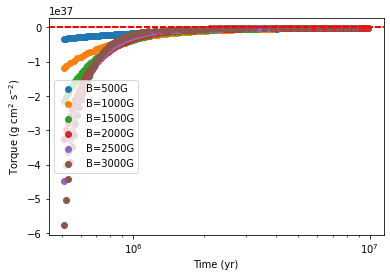

time: 33.4 s (started: 2021-01-26 22:40:31 +00:00)


In [ ]:
for i in range(500,3500,500):
  plt.scatter(REFUGEE(5,0.01,10e6,i,0.1,1,1e6,0.1)[0], REFUGEE(5,0.01,10e6,i,0.1,1,1e6,0.1)[1], label='B=%iG' %(i)) #REFUGEE(Prot, Mdisk, Tdisk, Bfield, betta, gamma, ta, apsw)
  plt.axhline(y=0, color='r', linestyle='--')
  plt.legend(loc='center left')
  plt.xscale('log')
  plt.xlabel('Time (yr)')
  plt.ylabel(r'Torque (g cm$^{2}$ s$^{-2}$)')

###Rotational Period (Plot as a function of B field)
(Prot=5d, Mdisk=0.01Msun,Betta=0.1,Gamma=1)

---



In [ ]:
for i in range(500,3500,500):
  plt.scatter(REFUGEE(5,0.1,10e6,i,0.01,1,1e6,0.01)[0],REFUGEE(5,0.1,10e6,i,0.01,1,1e6,0.01)[4], label='B=%iG, apsw=0.01' %(i)) #REFUGEE(Prot, Mdisk, Tdisk, Bfield, betta, gamma, ta)
  #plt.scatter(REFUGEE(5,0.1,10e6,i,0.01,1,1e6,0.1)[0],REFUGEE(5,0.1,10e6,i,0.01,1,1e6,0.1)[4], label='B=%iG, apsw=0.1' %(i)) #REFUGEE(Prot, Mdisk, Tdisk, Bfield, betta, gamma, ta)
  #plt.scatter(REFUGEE(5,0.01,10e6,i,0.1,1,1e6)[0],REFUGEE(5,0.01,10e6,i,0.1,1,1e6)[4], label='B=%iG, ta=1Myr' %(i)) #REFUGEE(Prot, Mdisk, Tdisk, Bfield, betta, gamma, ta)
  #plt.scatter(REFUGEE(5,0.01,10e6,i,0.1,1,5e5)[0],REFUGEE(5,0.01,10e6,i,0.1,1,5e5)[4], label='B=%iG, ta=0.5Myr' %(i)) #REFUGEE(Prot, Mdisk, Tdisk, Bfield, betta, gamma, ta)
  plt.legend()#loc='center left')
  plt.xscale('log')
  plt.xlabel('Time (yr)')
  plt.ylabel(r'$P_{rot}$ (day)')

#Torque Total (Savefig)
(Prot=5d, Mdisk=0.01Msun,Betta=0.01,Gamma=1)

---

---




In [ ]:
for j in range(1,13,3):
  for i in range(2000,3500,500):
    plt.scatter(REFUGEE(5,j/100,10e6,i,0.01,1)[0],REFUGEE(5,j/100,10e6,i,0.01,1)[1], label='$B=$%iG, $M_{d}=$%.2f$M_{\odot}$' %(i,j/100))
    plt.axhline(y=0, color='r', linestyle='--')
    plt.legend(loc="upper right")
    #plt.tight_layout()
    plt.ylim(-1e37,1e37)
    plt.xscale('log')
    plt.xlabel('Time (yr)')
    plt.ylabel(r'Torque (g cm$^{2}$ s$^{-2}$)')
    plt.savefig('/drive/My Drive/Colab Notebooks/REFUGEE/ROTEVOL_GRID/Torque_B_%iG_Md_%.2fMsun_betta_001_gamma_1.png' %(i,j/100), dpi=300)
    plt.cla()
    plt.close()

#Rotational Period (Savefig)
(Prot=5d, Mdisk=0.01Msun,Betta=0.01,Gamma=1)

---

---

In [ ]:
for i in range(1,11,1):
  for j in range(0,3,1):
      for k in range(1,11,1):
        plt.scatter(REFUGEE(5,i/100,10e6,500,np.power(10,j)/100,1,2e6,k/100)[0],REFUGEE(5,i/100,10e6,500,np.power(10,j)/100,1,2e6,k/100)[4], label='$B=$500G')
        plt.scatter(REFUGEE(5,i/100,10e6,1000,np.power(10,j)/100,1,2e6,k/100)[0],REFUGEE(5,i/100,10e6,1000,np.power(10,j)/100,1,2e6,k/100)[4], label='$B=$1000G')
        plt.scatter(REFUGEE(5,i/100,10e6,1500,np.power(10,j)/100,1,2e6,k/100)[0],REFUGEE(5,i/100,10e6,1500,np.power(10,j)/100,1,2e6,k/100)[4], label='$B=$1500G')
        plt.scatter(REFUGEE(5,i/100,10e6,2000,np.power(10,j)/100,1,2e6,k/100)[0],REFUGEE(5,i/100,10e6,2000,np.power(10,j)/100,1,2e6,k/100)[4], label='$B=$2000G')
        plt.scatter(REFUGEE(5,i/100,10e6,2500,np.power(10,j)/100,1,2e6,k/100)[0],REFUGEE(5,i/100,10e6,2500,np.power(10,j)/100,1,2e6,k/100)[4], label='$B=$2500G')
        plt.scatter(REFUGEE(5,i/100,10e6,3000,np.power(10,j)/100,1,2e6,k/100)[0],REFUGEE(5,i/100,10e6,3000,np.power(10,j)/100,1,2e6,k/100)[4], label='$B=$3000G')
        plt.title(r'$M_{disk}=$%.2f$M_{\odot}$, $\beta=$%.2f, $\gamma_{c}=$1, $\chi=$%.2f' %(i/100,np.power(10,j)/100,k/100))
        #plt.axhline(y=0, color='r', linestyle='--')
        plt.legend(loc="upper right")
        #plt.tight_layout()
        plt.ylim(0,15)
        plt.xscale('log')
        plt.xlabel('Time (yr)')
        plt.ylabel(r'$P_{rot}$ (day)')
        plt.savefig('/drive/My Drive/Colab Notebooks/REFUGEE/ROTEVOL_GRID/Period/winds/Prot_Mdisk_%.2fMsun_Beta_%.2f_Gamma_1_Chi_%.2f.png' %(i/100,np.power(10,j)/100,k/100), dpi=300)
        plt.cla()
        plt.close()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: scipy.genfromtxt is deprecated and will be removed in SciPy 2.0.0, use numpy.genfromtxt instead


time: 3h 6min 31s (started: 2021-02-01 00:11:49 +00:00)


#Rotational Velocity (Savefig)

---

---

In [ ]:
for i in range(1,11,1):
  for j in range(0,3,1):
    plt.scatter(REFUGEE(8,i/100,10e6,500,np.power(10,j)/100,1)[0],REFUGEE(8,i/100,10e6,500,np.power(10,j)/100,1)[3], label='$B=$500G')
    plt.scatter(REFUGEE(8,i/100,10e6,1000,np.power(10,j)/100,1)[0],REFUGEE(8,i/100,10e6,1000,np.power(10,j)/100,1)[3], label='$B=$1000G')
    plt.scatter(REFUGEE(8,i/100,10e6,1500,np.power(10,j)/100,1)[0],REFUGEE(8,i/100,10e6,1500,np.power(10,j)/100,1)[3], label='$B=$1500G')
    plt.scatter(REFUGEE(8,i/100,10e6,2000,np.power(10,j)/100,1)[0],REFUGEE(8,i/100,10e6,2000,np.power(10,j)/100,1)[3], label='$B=$2000G')
    plt.scatter(REFUGEE(8,i/100,10e6,2500,np.power(10,j)/100,1)[0],REFUGEE(8,i/100,10e6,2500,np.power(10,j)/100,1)[3], label='$B=$2500G')
    plt.scatter(REFUGEE(8,i/100,10e6,3000,np.power(10,j)/100,1)[0],REFUGEE(8,i/100,10e6,3000,np.power(10,j)/100,1)[3], label='$B=$3000G')
    plt.title(r'$M_{disk}=$%.2f$M_{\odot}$, $\beta=$%.2f, $\gamma_{c}=$1' %(i/100,np.power(10,j)/100))
    #plt.axhline(y=0, color='r', linestyle='--')
    plt.legend(loc="upper right")
    #plt.tight_layout()
    plt.ylim(1,360)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Time (yr)')
    plt.ylabel(r'$V_{rot}$ (km/s)')
    plt.savefig('/drive/My Drive/Colab Notebooks/REFUGEE/ROTEVOL_GRID/Velocity/8d/Vrot_Mdisk_%.2fMsun_Beta_%.2f_Gamma_1.png' %(i/100,np.power(10,j)/100), dpi=300)
    plt.cla()
    plt.close()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: scipy.genfromtxt is deprecated and will be removed in SciPy 2.0.0, use numpy.genfromtxt instead


time: 21min 14s


In [ ]:
for j in range(0,6,1):
  plt.scatter(REFUGEE(5,0.01,10e6,500,0.1,np.power(10,j)/100)[0],REFUGEE(5,0.01,10e6,500,0.1,np.power(10,j)/100)[4], label='$B=$500G')
  plt.scatter(REFUGEE(5,0.01,10e6,1000,0.1,np.power(10,j)/100)[0],REFUGEE(5,0.01,10e6,1000,0.1,np.power(10,j)/100)[4], label='$B=$1000G')
  plt.scatter(REFUGEE(5,0.01,10e6,1500,0.1,np.power(10,j)/100)[0],REFUGEE(5,0.01,10e6,1500,0.1,np.power(10,j)/100)[4], label='$B=$1500G')
  plt.scatter(REFUGEE(5,0.01,10e6,2000,0.1,np.power(10,j)/100)[0],REFUGEE(5,0.01,10e6,2000,0.1,np.power(10,j)/100)[4], label='$B=$2000G')
  plt.scatter(REFUGEE(5,0.01,10e6,2500,0.1,np.power(10,j)/100)[0],REFUGEE(5,0.01,10e6,2500,0.1,np.power(10,j)/100)[4], label='$B=$2500G')
  plt.scatter(REFUGEE(5,0.01,10e6,3000,0.1,np.power(10,j)/100)[0],REFUGEE(5,0.01,10e6,3000,0.1,np.power(10,j)/100)[4], label='$B=$3000G')
  plt.title(r'$M_{disk}=$0.01$M_{\odot}$, $\beta=$0.1, $\gamma_{c}=$%.2f' %(np.power(10,j)/100))
  #plt.axhline(y=0, color='r', linestyle='--')
  plt.legend(loc="upper right")
  #plt.tight_layout()
  plt.ylim(0,15)
  plt.xscale('log')
  plt.xlabel('Time (yr)')
  plt.ylabel(r'$P_{rot}$ (day)')
  plt.savefig('/drive/My Drive/Colab Notebooks/REFUGEE/ROTEVOL_GRID/Period/5d/Prot_Mdisk_0.01Msun_Beta_0.1_Gamma_%.2f.png' %(np.power(10,j)/100), dpi=300)
  plt.cla()
  plt.close()